# About this kernel

* **Preprocessing**: Discard all of the training data that have all 4 masks missing. We will only train on images that have at least 1 mask, so that our classifier does not overfit on empty masks.
* **Step 1 - Discard Images**: Use the DenseNet classifier trained in [this kernel](https://www.kaggle.com/xhlulu/severstal-steel-predict-missing-masks) to predict all of the test images that will have all 4 masks missing. We will automatically set the RLEs of those images to null.
* **Step 2 - U-Net**: Train the same model from [Simple Keras U-Net Boilerplate](https://www.kaggle.com/xhlulu/severstal-simple-keras-u-net-boilerplate) on the "filtered" training data. Then, perform inference only on test images that were not discarded in step 1.
* **Submission**: We will now combine the dataframe containing the discarded test images with the dataframe containing test images predicted in step 2, and submit everything.


## Changelog
* V8: Changed sign of the `missing_model` threshold, since we are only keeping the ones with low probability of having no defect.
* V9: Fixed import for the discarding CNNs, which was updated to DenseNet.


## References
* Data generator: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
* RLE encoding and decoding: https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
* Architecture: https://www.kaggle.com/jesperdramsch/intro-chest-xray-dicom-viz-u-nets-full-data
* Mask encoding: https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/data
* Step 1 Original Kernel: https://www.kaggle.com/xhlulu/severstal-steel-predict-missing-masks
* Step 2 Original Kernel: https://www.kaggle.com/xhlulu/severstal-simple-keras-u-net-boilerplate

In [1]:
import os
import json
import gc

import cv2
import keras
from keras import backend as K
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
C:\Users\Lam Family\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Lam Family\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Lam Family\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\La

# Preprocessing

In [2]:
train_df = pd.read_csv('./input/train.csv')
train_df['ImageId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[1])
train_df['hasMask'] = ~ train_df['EncodedPixels'].isna()

print(train_df.shape)
train_df.head()

(50272, 5)


,ImageId_ClassId,EncodedPixels,ImageId,ClassId,hasMask
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1,True
1,0002cc93b.jpg_2,NaN,0002cc93b.jpg,2,False
2,0002cc93b.jpg_3,NaN,0002cc93b.jpg,3,False
3,0002cc93b.jpg_4,NaN,0002cc93b.jpg,4,False
4,00031f466.jpg_1,NaN,00031f466.jpg,1,False


In [3]:
mask_count_df = train_df.groupby('ImageId').agg(np.sum).reset_index()
mask_count_df.sort_values('hasMask', ascending=False, inplace=True)
print(mask_count_df.shape)
mask_count_df.head()

(12568, 2)


,ImageId,hasMask
10803,db4867ee8.jpg,3.0
11776,ef24da2ba.jpg,3.0
6284,7f30b9c64.jpg,2.0
9421,bf0c81db6.jpg,2.0
9615,c314f43f3.jpg,2.0


In [13]:
len(mask_count_df)

12568

In [4]:
sub_df = pd.read_csv('./input/sample_submission.csv')
sub_df['ImageId'] = sub_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
test_imgs = pd.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])
test_imgs.head()

,ImageId
0,004f40c73.jpg
1,006f39c41.jpg
2,00b7fb703.jpg
3,00bbcd9af.jpg
4,0108ce457.jpg


In [11]:
non_missing_train_idx = mask_count_df[mask_count_df['hasMask'] > 0]
non_missing_train_idx.head()

,ImageId,hasMask
10803,db4867ee8.jpg,3.0
11776,ef24da2ba.jpg,3.0
6284,7f30b9c64.jpg,2.0
9421,bf0c81db6.jpg,2.0
9615,c314f43f3.jpg,2.0


In [12]:
non_missing_train_idx.index

Int64Index([10803, 11776,  6284,  9421,  9615,  9583,  1637,  1650,  1666,
             9472,
            ...
             4205,  4033,  4426,  4421,  4425,  3780,  3779,  4422,  4036,
             4419],
           dtype='int64', length=6666)

# Step 1: Remove test images without defects

Most of the stuff below is hidden, since it's copied from my previous kernels.

In [6]:
def load_img(code, base, resize=True):
    path = f'{base}/{code}'
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if resize:
        img = cv2.resize(img, (256, 256))
    
    return img

def validate_path(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [10]:
BATCH_SIZE = 64
def create_test_gen():
    return ImageDataGenerator(rescale=1/255.).flow_from_dataframe(
        test_imgs,
        directory='./input/test_images/',
        x_col='ImageId',
        class_mode=None,
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        shuffle=False
    )

test_gen = create_test_gen()

Found 1801 validated image filenames.


In [8]:
remove_model = load_model('../input/severstal-predict-missing-masks/model.h5')
remove_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 8, 8, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

Beware: Messy code below!

In [9]:
test_missing_pred = remove_model.predict_generator(
    test_gen,
    steps=len(test_gen),
    verbose=1
)

test_imgs['allMissing'] = test_missing_pred
test_imgs.head()

29/29 [==============================] - 20s 678ms/step


,ImageId,allMissing
0,004f40c73.jpg,0.507990
1,006f39c41.jpg,1.000000
2,00b7fb703.jpg,0.999988
3,00bbcd9af.jpg,0.000036
4,0108ce457.jpg,1.000000


In [10]:
filtered_test_imgs = test_imgs[test_imgs['allMissing'] < 0.5]
print(filtered_test_imgs.shape)
filtered_test_imgs.head()

(480, 2)


,ImageId,allMissing
3,00bbcd9af.jpg,0.000036
5,0109b68ec.jpg,0.181035
6,010ec96b4.jpg,0.167333
9,01b47d973.jpg,0.001195
18,037e7564c.jpg,0.268913


`filtered_sub_df` contains all of the images with at least one mask. `null_sub_df` contains all the images with exactly 4 missing masks.

In [11]:
filtered_mask = sub_df['ImageId'].isin(filtered_test_imgs["ImageId"].values)
filtered_sub_df = sub_df[filtered_mask].copy()
null_sub_df = sub_df[~filtered_mask].copy()
null_sub_df['EncodedPixels'] = null_sub_df['EncodedPixels'].apply(
    lambda x: ' ')

filtered_sub_df.reset_index(drop=True, inplace=True)
filtered_test_imgs.reset_index(drop=True, inplace=True)

print(filtered_sub_df.shape)
print(null_sub_df.shape)

filtered_sub_df.head()

(1920, 3)
(5284, 3)


,ImageId_ClassId,EncodedPixels,ImageId
0,00bbcd9af.jpg_1,1 1,00bbcd9af.jpg
1,00bbcd9af.jpg_2,1 1,00bbcd9af.jpg
2,00bbcd9af.jpg_3,1 1,00bbcd9af.jpg
3,00bbcd9af.jpg_4,1 1,00bbcd9af.jpg
4,0109b68ec.jpg_1,1 1,0109b68ec.jpg


# Step 2: Keras U-Net

Most of the stuff below is hidden, since it's copied from my previous kernels.

## Utility Functions

In [12]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

def build_masks(rles, input_shape):
    depth = len(rles)
    masks = np.zeros((*input_shape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            masks[:, :, i] = rle2mask(rle, input_shape)
    
    return masks

def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles

## Data Generator

In [13]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='../input/severstal-steel-defect-detection/train_images',
                 batch_size=32, dim=(256, 1600), n_channels=1,
                 n_classes=4, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_grayscale(img_path)
            
            # Store samples
            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch):
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img

In [14]:
BATCH_SIZE = 16

train_idx, val_idx = train_test_split(
    non_missing_train_idx.index,  # NOTICE DIFFERENCE
    random_state=2019, 
    test_size=0.15
)

train_generator = DataGenerator(
    train_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

val_generator = DataGenerator(
    val_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

## Model

In [15]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [16]:
def build_model(input_shape):
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

    c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='relu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='relu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
    
    return model

In [17]:
model = build_model((256, 1600, 1))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 1600, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 1600, 8) 80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 1600, 8) 584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 800, 8)  0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [18]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    use_multiprocessing=False,
    workers=1,
    epochs=10
)

Epoch 1/10
354/354 [==============================] - 203s 573ms/step - loss: 0.3985 - dice_coef: 0.0120 - val_loss: 0.1258 - val_dice_coef: 1.0934e-05
Epoch 2/10
354/354 [==============================] - 185s 523ms/step - loss: 0.0520 - dice_coef: 0.0371 - val_loss: 0.0332 - val_dice_coef: 0.0559
Epoch 3/10
354/354 [==============================] - 184s 519ms/step - loss: 0.0306 - dice_coef: 0.0996 - val_loss: 0.0312 - val_dice_coef: 0.0942
Epoch 4/10
354/354 [==============================] - 184s 520ms/step - loss: 0.0286 - dice_coef: 0.1471 - val_loss: 0.0272 - val_dice_coef: 0.1829
Epoch 5/10
354/354 [==============================] - 184s 519ms/step - loss: 0.0267 - dice_coef: 0.1961 - val_loss: 0.0274 - val_dice_coef: 0.1462
Epoch 6/10
354/354 [==============================] - 183s 517ms/step - loss: 0.0240 - dice_coef: 0.2574 - val_loss: 0.0218 - val_dice_coef: 0.3179
Epoch 7/10
354/354 [==============================] - 184s 520ms/step - loss: 0.0231 - dice_coef: 0.2806 - v

## Evaluation

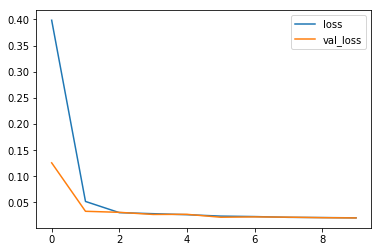

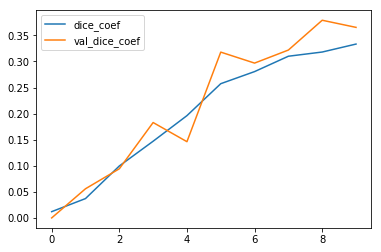

In [19]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['dice_coef', 'val_dice_coef']].plot()

## Predict masks on non-discarded images

In [20]:
model.load_weights('model.h5')
test_df = []

for i in range(0, filtered_test_imgs.shape[0], 300):
    batch_idx = list(
        range(i, min(filtered_test_imgs.shape[0], i + 300))
    )
    
    test_generator = DataGenerator(
        batch_idx,
        df=filtered_test_imgs,
        shuffle=False,
        mode='predict',
        base_path='../input/severstal-steel-defect-detection/test_images',
        target_df=filtered_sub_df,
        batch_size=1,
        n_classes=4
    )
    
    batch_pred_masks = model.predict_generator(
        test_generator, 
        workers=1,
        verbose=1,
        use_multiprocessing=False
    )
    
    for j, b in tqdm(enumerate(batch_idx)):
        filename = filtered_test_imgs['ImageId'].iloc[b]
        image_df = filtered_sub_df[filtered_sub_df['ImageId'] == filename].copy()
        
        pred_masks = batch_pred_masks[j, ].round().astype(int)
        pred_rles = build_rles(pred_masks)
        
        image_df['EncodedPixels'] = pred_rles
        test_df.append(image_df)
        
    gc.collect()

300/300 [==============================] - 7s 24ms/step


300it [00:03, 80.26it/s]


180/180 [==============================] - 3s 14ms/step


180it [00:02, 82.65it/s]


# Submission

In [21]:
test_df = pd.concat(test_df)
print(test_df.shape)
test_df.head()

(1920, 3)


,ImageId_ClassId,EncodedPixels,ImageId
0,00bbcd9af.jpg_1,,00bbcd9af.jpg
1,00bbcd9af.jpg_2,,00bbcd9af.jpg
2,00bbcd9af.jpg_3,157674 1 157678 1 157682 1 157686 1 157926 21 ...,00bbcd9af.jpg
3,00bbcd9af.jpg_4,,00bbcd9af.jpg
4,0109b68ec.jpg_1,,0109b68ec.jpg


Now, we combine results from the predicted masks with the rest of images that our first CNN classified as having all 4 masks missing.

In [22]:
final_submission_df = pd.concat([test_df, null_sub_df])
print(final_submission_df.shape)
final_submission_df.head()

(7204, 3)


,ImageId_ClassId,EncodedPixels,ImageId
0,00bbcd9af.jpg_1,,00bbcd9af.jpg
1,00bbcd9af.jpg_2,,00bbcd9af.jpg
2,00bbcd9af.jpg_3,157674 1 157678 1 157682 1 157686 1 157926 21 ...,00bbcd9af.jpg
3,00bbcd9af.jpg_4,,00bbcd9af.jpg
4,0109b68ec.jpg_1,,0109b68ec.jpg


In [23]:
final_submission_df[['ImageId_ClassId', 'EncodedPixels']].to_csv('submission.csv', index=False)